In [1]:
from functools import reduce
import pandas as pd
pd.options.display.max_columns = None
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt
import matplotlib as mpl
from jupyterthemes import jtplot
import numpy as np
import seaborn as sns
sns.set()
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib notebook
jtplot.style(context='notebook', ticks=True, grid=False)

rcDict = {
    'font.family': 'sans-serif',
    'font.sans-serif': ['Lato'],
    'font.weight': 'medium',
    'font.size': 8, 
    'text.hinting': 'native',
    'text.hinting_factor': 2
}

mpl.rcParams.update(rcDict)

In [2]:
timeseries_url = "https://coronadatascraper.com/timeseries.csv"
country_codes_url = "https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes/raw/master/all/all.csv"
jhu_url_prefix = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/"
def jhu_url(date):
    ts = pd.to_datetime(str(date))
    d = ts.strftime('%m-%d-%Y.csv')
    return jhu_url_prefix + d


In [3]:
country_codes = pd.read_csv(country_codes_url).set_index('alpha-3')['name']
country_codes.name = 'country'
country_codes.update(pd.Series({'USA': 'USA', 'GBR': 'UK', 'KOR': 'South Korea', 'XKX': 'Kosovo', 'Bahamas, The': 'Bahamas', 'Cape Verde': 'Cape Verde', 'East Timor': 'East Timor', 'Syria': 'Syria'}))

In [4]:
timeseries = pd.read_csv(timeseries_url, parse_dates=['date'])
timeseries.loc[(timeseries['country'] == 'CAN') & (timeseries['state'] == 'Total'), ['state']] = np.nan
columns = list(timeseries.columns)
columns.remove('date')
columns = ['date'] + columns
timeseries = timeseries[columns]

data_columns = ['cases', 'deaths', 'active', 'recovered']

def get_combined_location(row):
    location_segs = [row['city'], row['county'], row['state'], row['country_code']]
    cleaned_location_segments = [seg for seg in location_segs if type(seg) is str]
    return ', '.join(cleaned_location_segments)

timeseries = (timeseries.rename({'country': 'country_code'}, axis='columns').join(country_codes, 'country_code'))
timeseries['location'] = timeseries.apply(get_combined_location, axis='columns')

def shift_dates(row, offset):
    date = row['date']
    return (date - offset) / pd.Timedelta(days=1)

def synthesize_columns(table):
    table['cases/deaths'] = table['cases'] / table['deaths']
    table['cases/100k'] = table['cases'] / table['population'] * 1e5
    for days_shift in [1,3,7]:
        for orig_column in ['recovered', 'deaths', 'cases', 'active']:
            table[f'{days_shift}d new {orig_column}'] = table[orig_column].diff(periods=days_shift)
    day_location_reached_75 = table[table['cases']>75]['date'].min()
    day_location_reached_75_active = table[table['active']>75]['date'].min()
    day_location_reached_1_per_100k = table[table['cases/100k']>1]['date'].min()
    table['days since 75 cases'] = table.apply(shift_dates, offset=day_location_reached_75, axis='columns')
    table['days since 75 active'] = table.apply(shift_dates, offset=day_location_reached_75_active, axis='columns')
    table['days since 1 case/100k people'] = table.apply(shift_dates, offset=day_location_reached_1_per_100k, axis='columns')
    return table


In [5]:

locations_to_correct = {
    'Ireland': timeseries['country_code'] == 'IRL',
    'United Kingdom': (timeseries['country_code'] == 'GBR') & (timeseries['state'].isnull())
}
timeseries[locations_to_correct['United Kingdom']]



,date,city,county,state,country_code,population,lat,long,url,cases,deaths,recovered,active,tested,growthFactor,country,location
9933,2020-03-12,NaN,NaN,NaN,GBR,64769452.0,55.191616,-3.192433,https://github.com/CSSEGISandData/COVID-19,456.0,8.0,18.0,430.0,NaN,NaN,UK,GBR
9934,2020-03-13,NaN,NaN,NaN,GBR,64769452.0,55.191616,-3.192433,https://github.com/CSSEGISandData/COVID-19,798.0,8.0,18.0,772.0,NaN,1.750000,UK,GBR
9935,2020-03-14,NaN,NaN,NaN,GBR,64769452.0,55.191616,-3.192433,https://github.com/CSSEGISandData/COVID-19,1140.0,21.0,18.0,1101.0,NaN,1.428571,UK,GBR
9936,2020-03-15,NaN,NaN,NaN,GBR,64769452.0,55.191616,-3.192433,https://github.com/CSSEGISandData/COVID-19,1140.0,21.0,18.0,1101.0,NaN,1.000000,UK,GBR
9937,2020-03-16,NaN,NaN,NaN,GBR,64769452.0,55.191616,-3.192433,https://github.com/CSSEGISandData/COVID-19,1543.0,55.0,20.0,1468.0,NaN,1.353509,UK,GBR
9938,2020-03-17,NaN,NaN,NaN,GBR,64769452.0,55.191616,-3.192433,https://github.com/CSSEGISandData/COVID-19,1950.0,55.0,52.0,1843.0,NaN,1.263772,UK,GBR
9939,2020-03-18,NaN,NaN,NaN,GBR,64769452.0,55.191616,-3.192433,https://github.com/CSSEGISandData/COVID-19,2626.0,71.0,65.0,2490.0,NaN,1.346667,UK,GBR
9940,2020-03-19,NaN,NaN,NaN,GBR,64769452.0,55.191616,-3.192433,https://github.com/CSSEGISandData/COVID-19,2689.0,137.0,65.0,2487.0,NaN,1.023991,UK,GBR
9941,2020-03-20,NaN,NaN,NaN,GBR,64769452.0,55.191616,-3.192433,https://github.com/CSSEGISandData/COVID-19,3983.0,177.0,65.0,3741.0,NaN,1.481220,UK,GBR
9942,2020-03-21,NaN,NaN,NaN,GBR,64769452.0,55.191616,-3.192433,https://github.com/CSSEGISandData/COVID-19,5018.0,233.0,65.0,4720.0,NaN,1.259854,UK,GBR


In [6]:
local_to_remote_map = {
    'cases': 'Confirmed',
    'recovered': 'Recovered',
    'active': 'Active',
    'deaths': 'Deaths'
}
first_date = np.datetime64('2020-03-23')
dates_to_correct = set(timeseries[timeseries['date'] >= first_date]['date'])
for date in dates_to_correct:
    jhu_table = pd.read_csv(jhu_url(date))
    for remote_region, query in locations_to_correct.items():
        jhu_query = jhu_table['Country_Region'] == remote_region
        jhu_query &= jhu_table['Province_State'].isnull()
        country_row = jhu_table[jhu_query].iloc[0]
        query &= timeseries['date'] == date
        for localkey, remotekey in local_to_remote_map.items():
            timeseries.loc[query, [localkey]] = country_row[remotekey]
            

In [7]:
all_dates = set(timeseries['date'])
all_locs = set(timeseries['location'])
loc_cols = ['country_code', 'state', 'county', 'city']

def rawquery(col, loc):
    return timeseries[timeseries[col] == loc]

def locquery(col, loc):
    basetable = rawquery(col, loc)
    if basetable.empty:
        return basetable
    if col == 'location':
        return basetable
    if col == 'country':
        col = 'country_code'
    i = loc_cols.index(col)
    nancols = loc_cols[i+1:]
    queries = [basetable[c].isnull() for c in nancols]
    if len(queries) == 0:
        print(6)
        return basetable
    nanquery = reduce(lambda q1, q2: q1 & q2, queries)
    return basetable[nanquery]

def loctable(loc):
    table = locquery('location', loc)
    if table.empty:
        table = locquery('country', loc)
    if table.empty:
        table = locquery('country_code', loc)
    if table.empty:
        table = locquery('state', loc)
    if table.empty:
        table = locquery('city', loc)
    return table
    
def loc_parts(loc):
    sample_row = loctable(loc).iloc[0]
    empty_cols = [col for col in loc_cols if sample_row[col] is np.nan]
    fixed_cols = [col for col in loc_cols if col not in empty_cols]
    fixed_dict ={ col:sample_row[col] for col in fixed_cols }
    return fixed_dict,empty_cols

def loc_query(fixed_dict):
    fixed_cols = fixed_dict.keys()
    queries = [(timeseries[col] == fixed_dict[col]) for col in fixed_cols]
    return reduce(lambda q1, q2: q1 & q2, queries)

def child_locs(loc):
    fixed_dict,empty_cols = loc_parts(loc)
    if len(empty_cols) == 0:
        return set()
    base_query = loc_query(fixed_dict)
    next_col = empty_cols[0]
    next_query = base_query & timeseries[next_col].notnull()
    child_table = timeseries[next_query]
    child_locs = set(child_table['location'])
    return child_locs

def missing_dates(table):
    loc_dates = set(table['date'])
    return all_dates.difference(loc_dates)

def child_loctable_bydate_sum(loc, date):
    childlocs = child_locs(loc)
    loc_q = timeseries['location'].isin(childlocs)
    date_q = timeseries['date'] == date
    return timeseries[loc_q & date_q][data_columns].sum()

def synthesize_row_from_childdata(loc, date):
    childrow = dict(child_loctable_bydate_sum(loc, date))
    samplerow = dict(loctable(loc).iloc[0])
    for col, value in childrow.items():
        samplerow[col] = value
    samplerow['date'] = date
    return samplerow
    
def synthesize_missing_dates(table):
    loc = table.iloc[0]['location']
    md = missing_dates(table)
    new_rows = [synthesize_row_from_childdata(loc, date) for date in md]
    table = table.append(new_rows).sort_values(by=['date']).reset_index(drop=True)
    return table

def location(loc):
    table = loctable(loc)
    table = synthesize_missing_dates(table)
    table = synthesize_columns(table)
    for col in data_columns:
        table.loc[table[col] == 0, [col]] = np.nan
    return table

In [75]:
locations_of_interest = {
    'WA':    ('WA, USA',          'teal'),
    'BC':    ('British Columbia', 'slateblue'),
    'Italy': ('Italy',            'chocolate'),
    'NY':    ('NY, USA',          'tomato'),
    'UK':    ('UK',               'royalblue'),
    'FL':    ('FL, USA',          'darkorange'),
    'IRL':   ('Ireland',          'forestgreen'),
    'Spain': ('Spain',            'goldenrod')
}
tables_interest = { k:location(loc) for k, (loc, _) in locations_of_interest.items() }
loc_colors = {k:col for k, (_, col) in locations_of_interest.items() }

hotspots = [
    'Italy',
    'Spain',
    'UK',
    'NY',
    'FL'
]

nearspots = [
    'BC',
    'WA',
    'IRL'
]

tables_hot = { loc:tables_interest[loc] for loc in hotspots }
tables_near = { loc:tables_interest[loc] for loc in nearspots }

In [76]:
class CovPlot(object):
    
    def __init__(self, tables, scale='log', value='cases', legend=True):
        self.fig = plt.figure(figsize=(9,6))
        self.ax = self.fig.add_subplot(111)
        self.tables = tables
        self.scale = scale
        self.value = value
        self.lines = dict()
        self.annotes = dict()
        self.prefix()
        self.legend = legend
        tablekeys = list(self.tables.keys())
        tablekeys.sort(key=lambda k: len(self.xs(self.tables[k])), reverse=True)
        for tablekey in tablekeys:
            self._line(tablekey)
        self.postfix()
        self.fig.show()
        
    def prefix(self):
        ax = self.ax
        ax.set_yscale(self.scale)
        ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
        ax.set_ylabel(self.value.capitalize())
        xlabel = self.xlabel()
        ax.set_xlabel(xlabel)
        ax.grid(True, which='major', linestyle='-', linewidth=1)
        ax.grid(True, which='minor', linestyle=':', linewidth=0.5)
        
    def filter_table(self, table):
        return table[table['date'] > np.datetime64('2020-03-01')]
        
    def xs(self, table):
        return table['date'].to_numpy()
    
    def ys(self, table):
        return table[self.value].to_numpy()
    
    def xlabel(self):
        return 'Date'
    
    def postfix(self):
        ax = self.ax
        ax.autoscale()
        xlabel = self.xlabel()
        if xlabel == 'Date':
            self.fig.autofmt_xdate()
        if self.legend:
            ax.legend()
        
    def _annote(self, line, tablekey):
        col = line.get_color()
        xs = line.get_xdata()
        ys = line.get_ydata() 
        if len(xs) == 0:
            return
        x = xs[-1]
        y = ys[-1]
        title = "{}: {:,}".format(tablekey, y)
        bbox_props = dict(boxstyle="Round4,pad=0.2", fc=col)
        self.annotes[tablekey] = self.ax.annotate(
            title,
            xy=(x, y),
            color='w',
            textcoords='offset points',
            xytext=(10, 0),
            ha='left',
            bbox=bbox_props,
            fontsize=8,
            fontweight='bold'
        )
        
    def _line(self, tablekey):
        table = self.tables[tablekey]
        table = self.filter_table(table)
        xs = self.xs(table)
        ys = self.ys(table)
        if len(xs) == 0:
            return
        color = None
        if tablekey in loc_colors:
            color = loc_colors[tablekey]
        line, = self.ax.plot(
            xs,
            ys,
            label=tablekey,
            linestyle='-',
            marker='o',
            markersize=3,
            color=color,
            linewidth=1
        )
        self._annote(line, tablekey)
        self.lines[tablekey] = line

class CovPlot75(CovPlot):
    def filter_table(self, table):
        return table[table['days since 75 cases'] >= 0]
        
    def xs(self, table):
        return table['days since 75 cases'].to_numpy()
    
    def xlabel(self):
        return 'Days Since 75 Cases'
    
    def postfix(self):
        ax = self.ax
        ax.autoscale()
        ax.set_xlim(left=0)
        ax.legend()

<IPython.core.display.Javascript object>


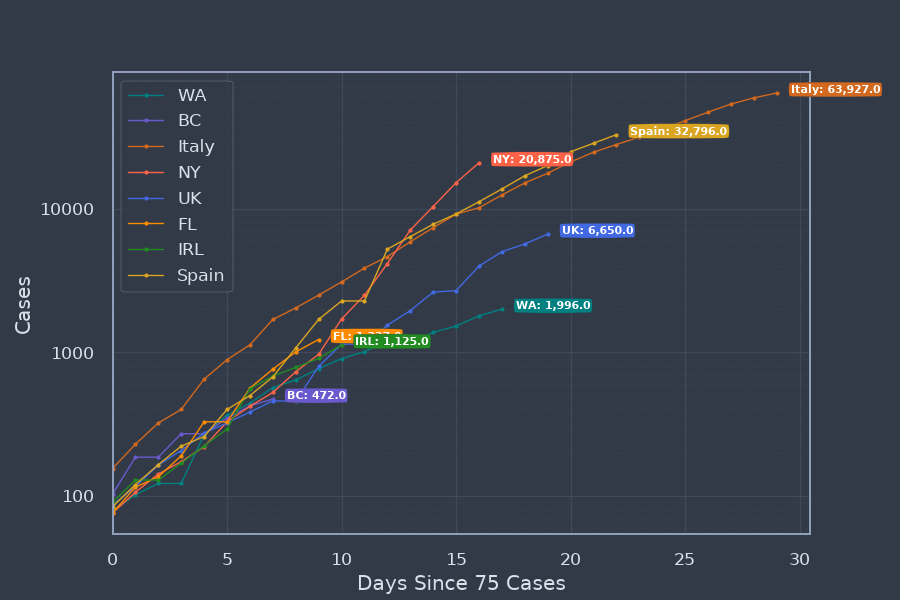

<IPython.core.display.Javascript object>


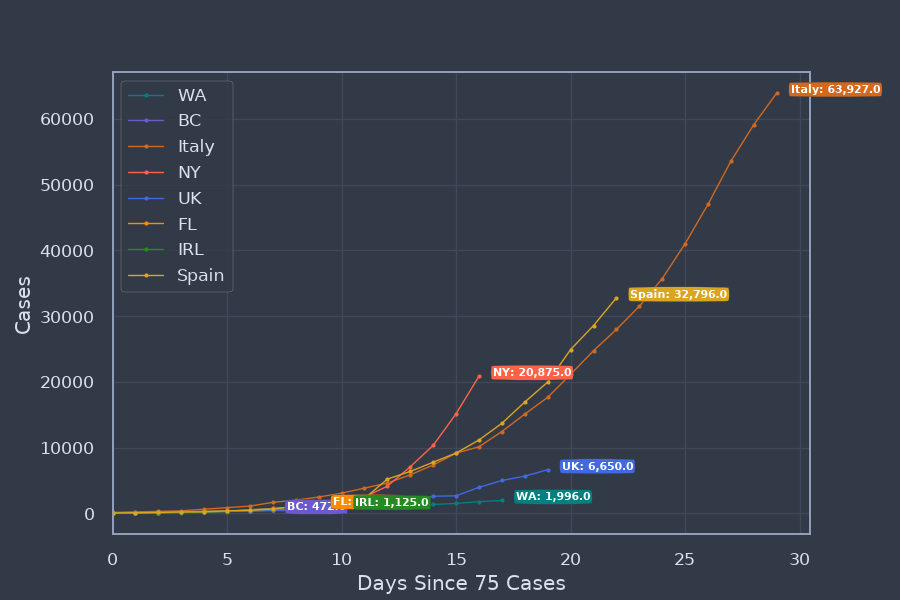

In [77]:

CovPlot75(tables_interest)
CovPlot75(tables_interest, scale='linear')

<IPython.core.display.Javascript object>


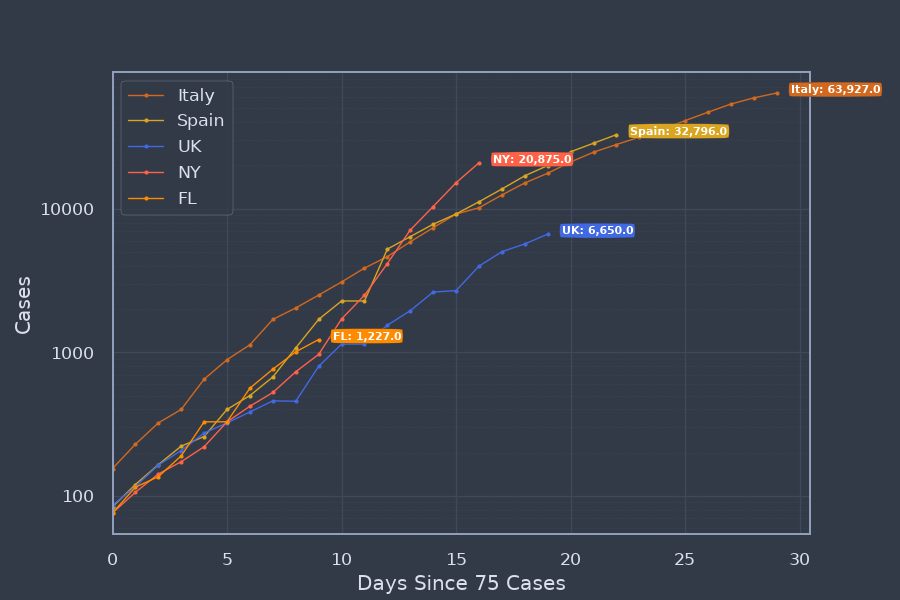

<IPython.core.display.Javascript object>


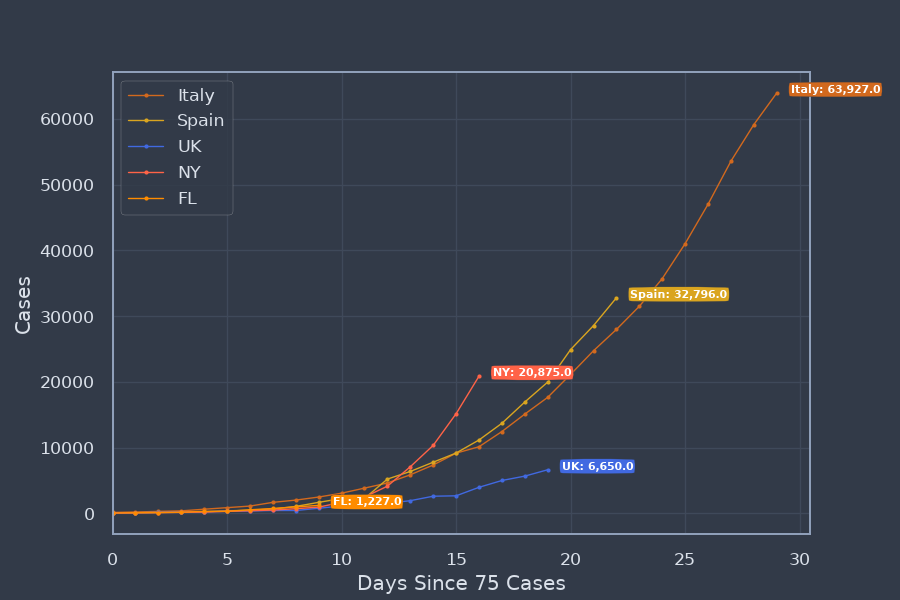

In [78]:
CovPlot75(tables_hot)
CovPlot75(tables_hot, scale='linear')

<IPython.core.display.Javascript object>


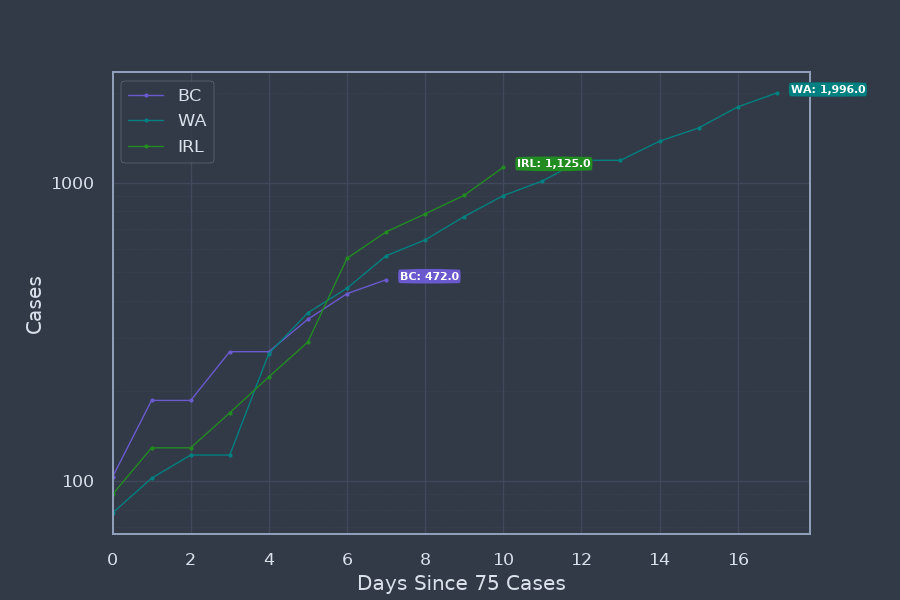

<IPython.core.display.Javascript object>


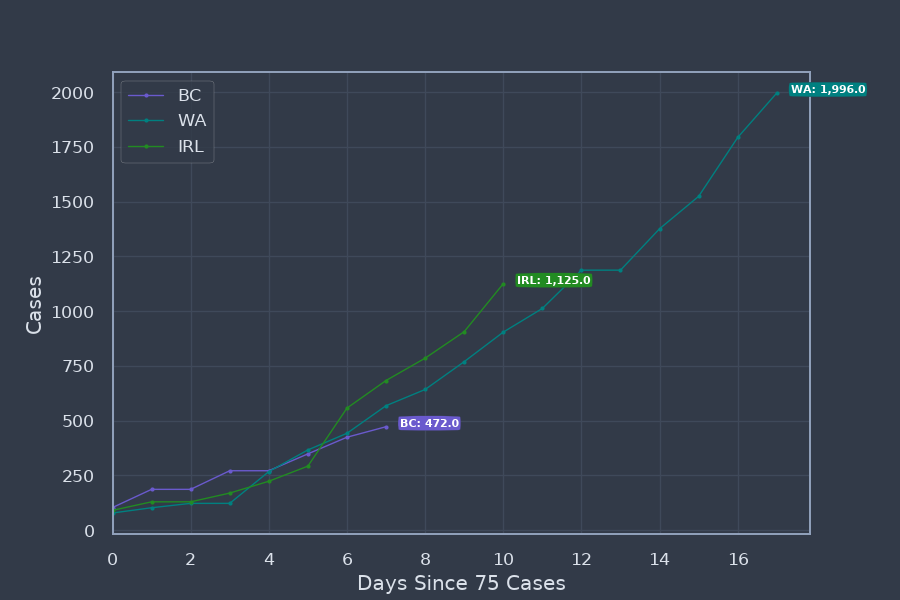

In [79]:
CovPlot75(tables_near)
CovPlot75(tables_near, scale='linear')

<IPython.core.display.Javascript object>


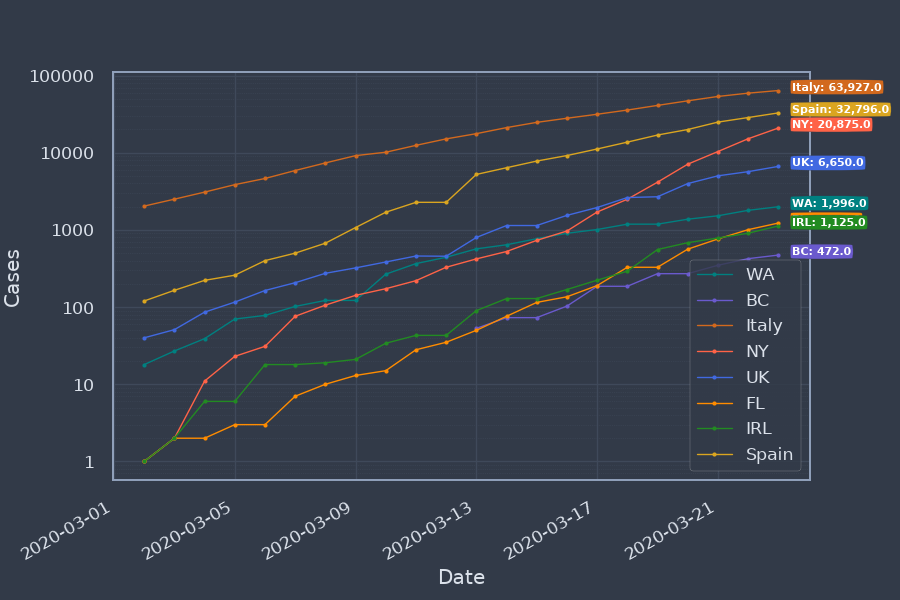

<IPython.core.display.Javascript object>


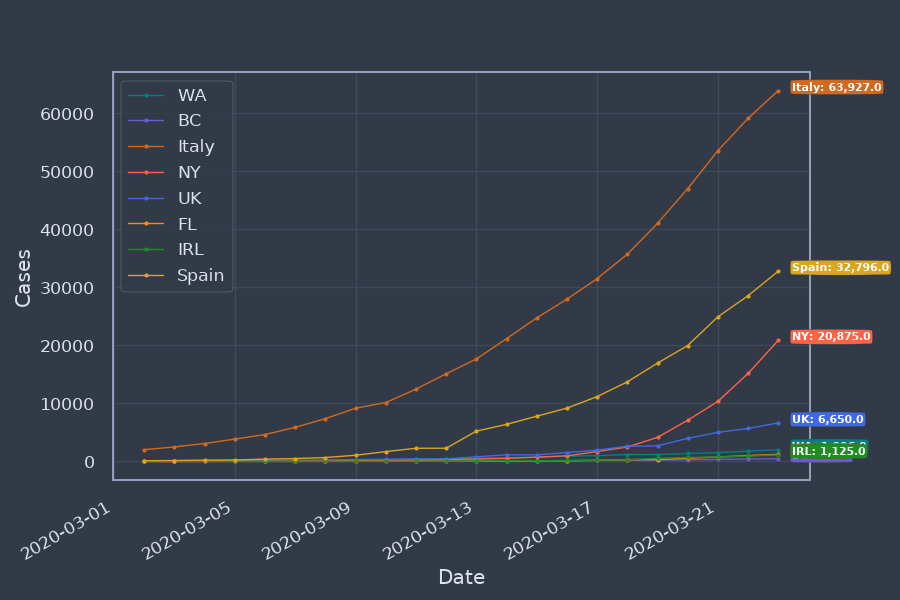

In [80]:
CovPlot(tables_interest)
CovPlot(tables_interest, scale='linear')

<IPython.core.display.Javascript object>


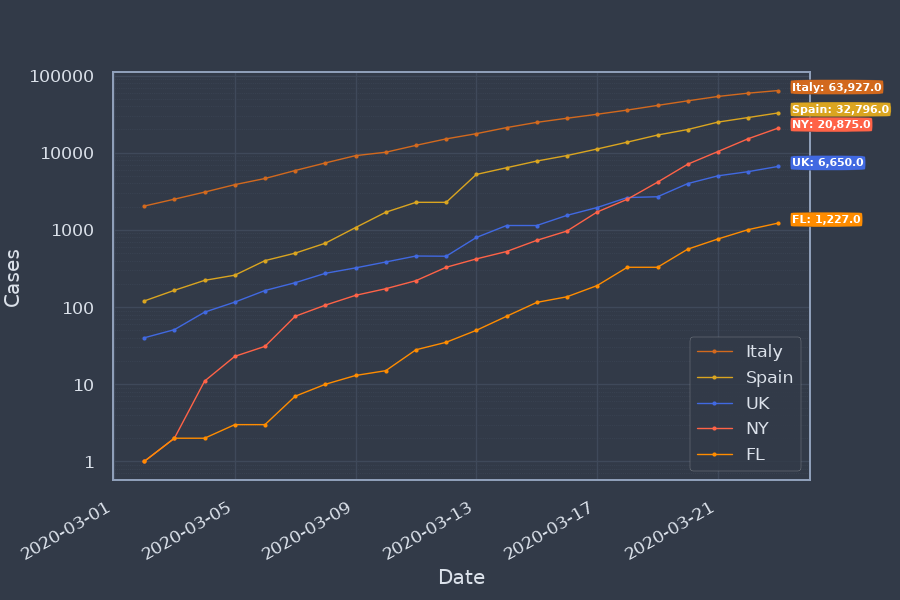

<IPython.core.display.Javascript object>


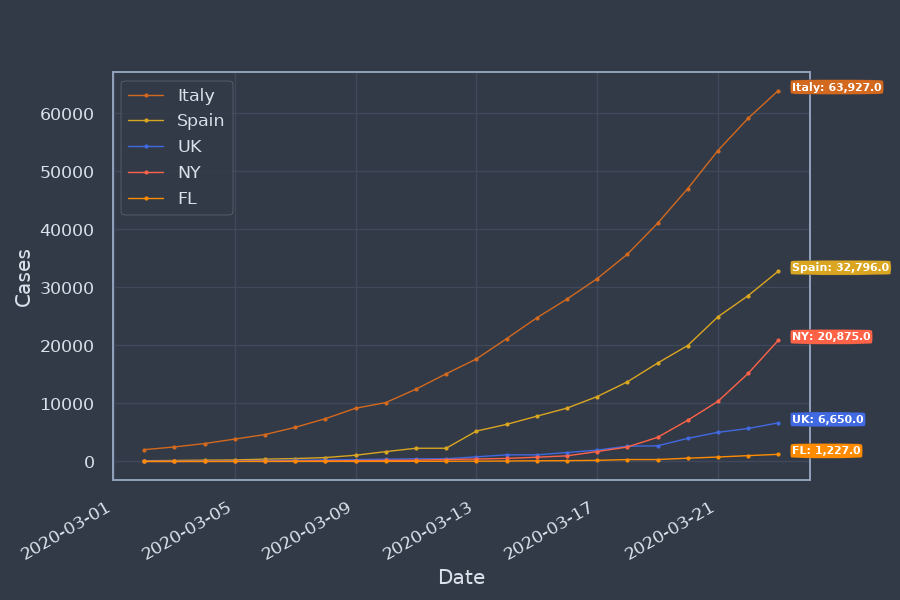

In [81]:
CovPlot(tables_hot)
CovPlot(tables_hot, scale='linear')

<IPython.core.display.Javascript object>


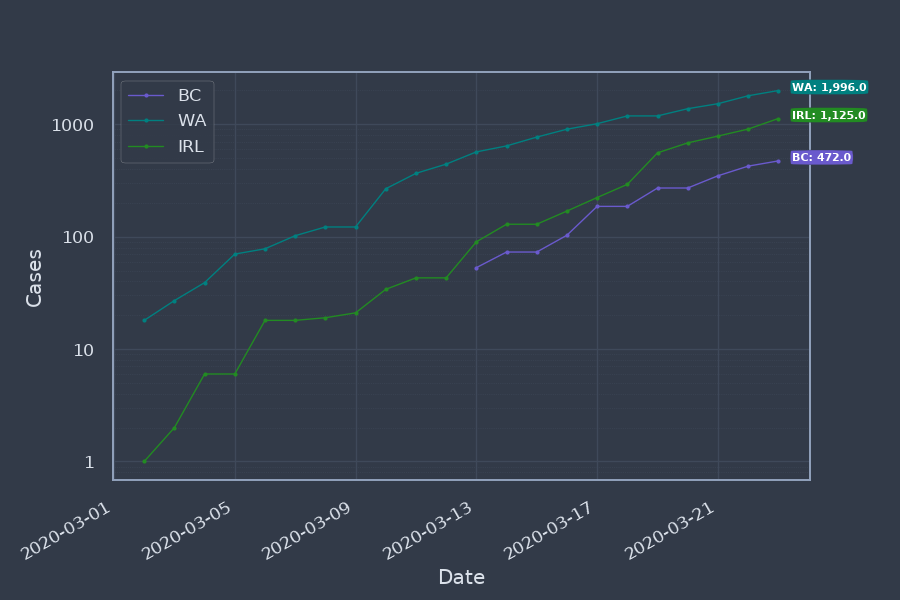

<IPython.core.display.Javascript object>


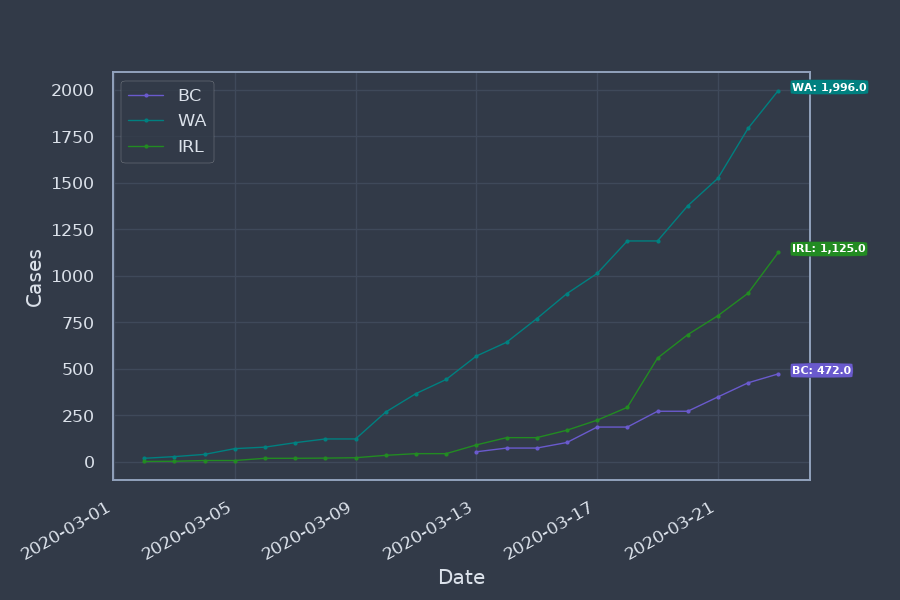

In [82]:
CovPlot(tables_near)
CovPlot(tables_near, scale='linear')

In [55]:
province_locs = {
    ('AB', 'Alberta, CAN'),
    ('BC', 'British Columbia, CAN'),
    ('MB', 'Manitoba, CAN'),
    ('NB', 'New Brunswick, CAN'),
    ('SK', 'Saskatchewan, CAN'),
    ('NS', 'Nova Scotia, CAN'),
    ('ON', 'Ontario, CAN'),
    ('QC', 'Quebec, CAN'),
}
provinces = { key:location(loc) for (key,loc) in province_locs }

<IPython.core.display.Javascript object>


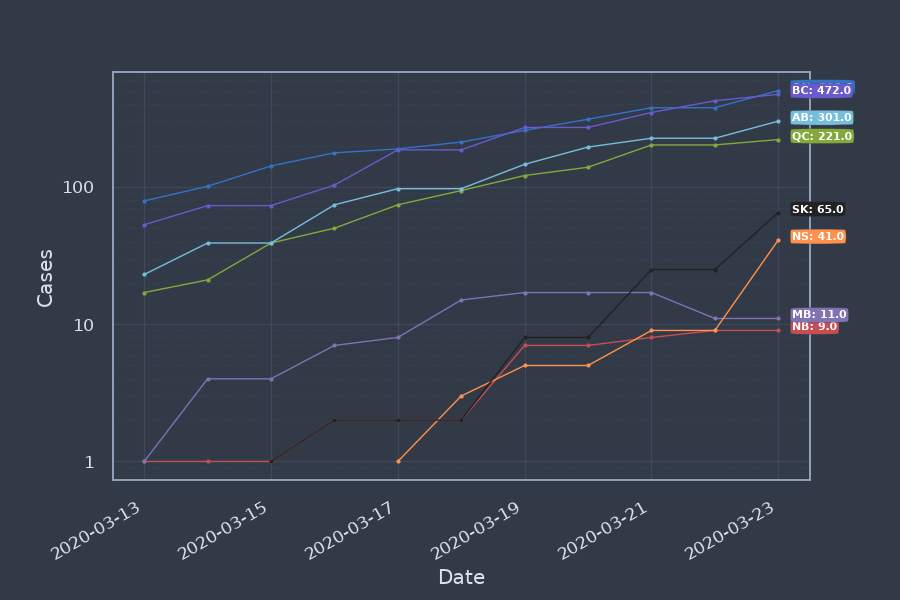

<IPython.core.display.Javascript object>


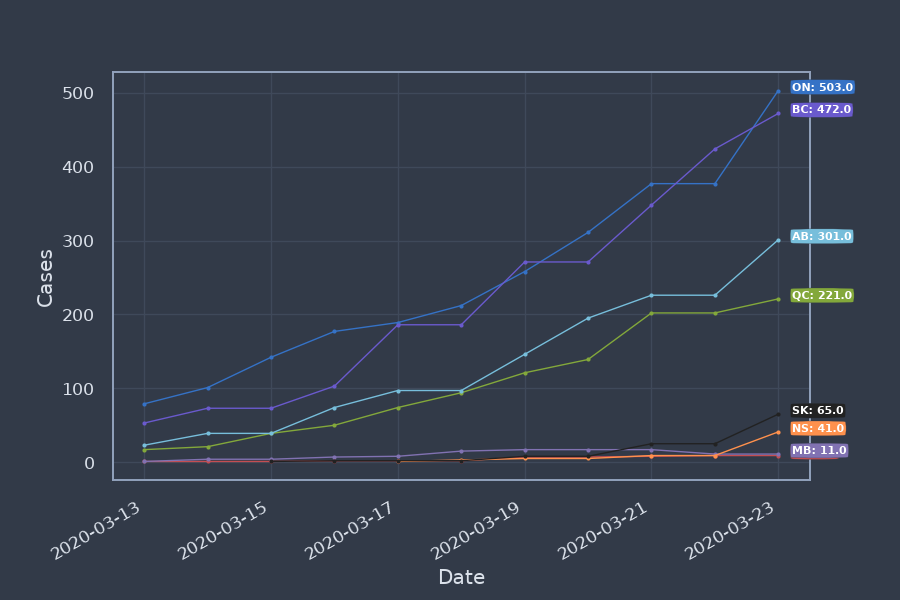

In [56]:
CovPlot(provinces, legend=False)
CovPlot(provinces, scale='linear', legend=False)

<IPython.core.display.Javascript object>


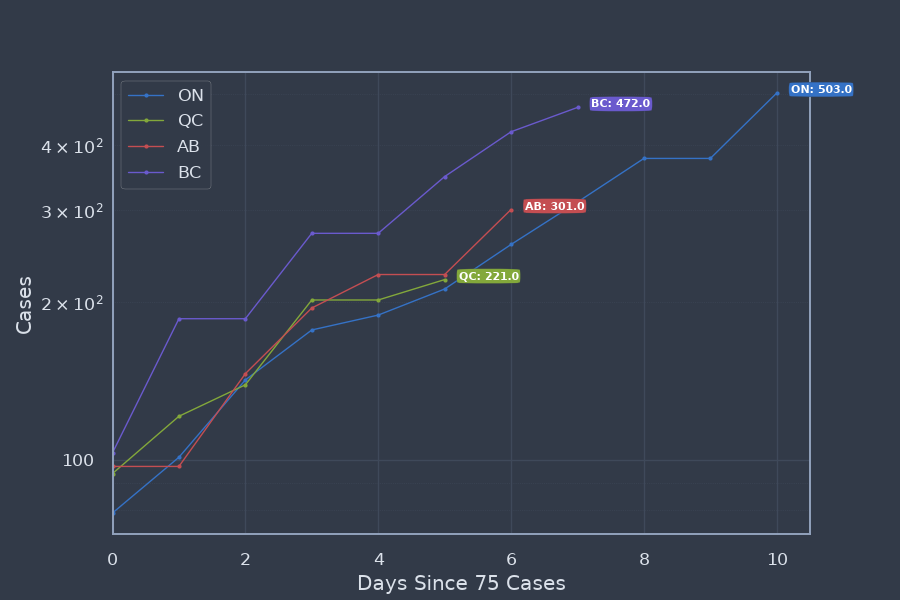

<IPython.core.display.Javascript object>


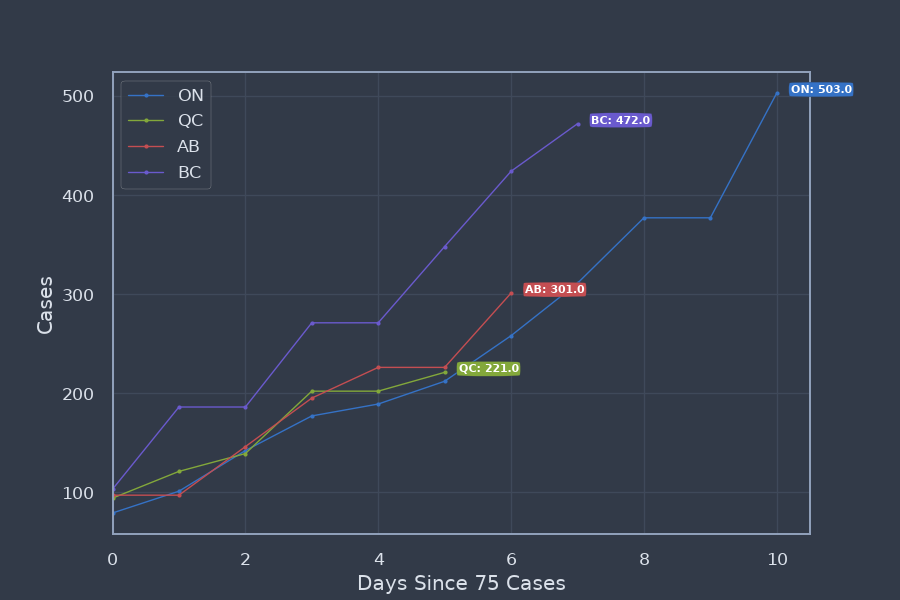

In [57]:
CovPlot75(provinces, legend=False)
CovPlot75(provinces, scale='linear', legend=False)

In [70]:
ny_vs_lom = {
    'New York': location('NY, USA'),
    'Lombardy': location('Lombardia, ITA'),
}


<IPython.core.display.Javascript object>


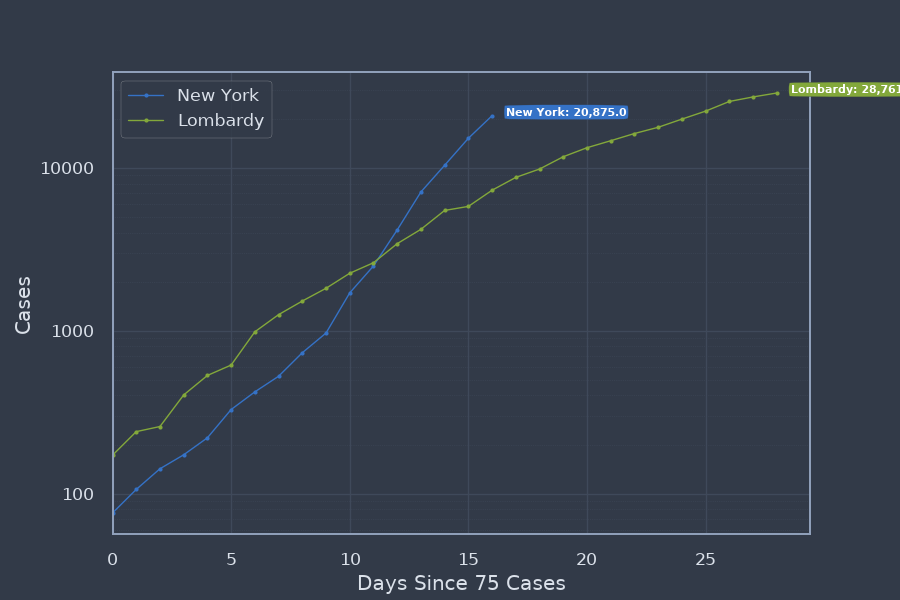

<IPython.core.display.Javascript object>


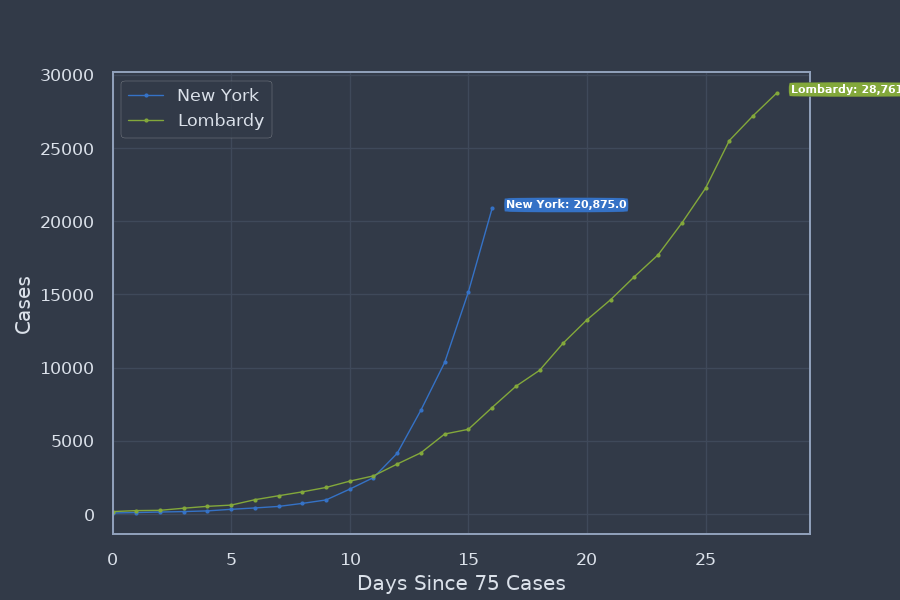

In [73]:
CovPlot75(ny_vs_lom)
CovPlot75(ny_vs_lom, scale='linear')

In [69]:
rawquery('county', 'Bronx County')

#CAN = statetable('CAN')
#can_tables = {'CAN': CAN, 'BC': BC, 'IE': IE}
#can_tables = {'CAN': CAN, 'BC': BC, 'IE': IE, 'UK': UK}

,date,city,county,state,country_code,population,lat,long,url,cases,deaths,recovered,active,tested,growthFactor,country,location
16260,2020-03-23,NaN,Bronx County,NY,USA,1432132.0,40.852099,-73.849268,https://coronavirus.health.ny.gov/county-count...,1999.0,NaN,NaN,1999.0,NaN,NaN,USA,"Bronx County, NY, USA"


In [ ]:
CovPlot(can_tables, scale='log')